# Spare-It EDA: Synthetic Image Stitching

In [347]:
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pycocotools.coco import COCO
from matplotlib import image

This is an example of a json file being read, with its categories and annotation IDs being stored.

In [348]:
#https://medium.com/p/732712631047
dataDir='./cocojson'
dataType='val'
anyFile='{}/Trash_fed220ac-f088-4708-9709-e23341f77d6a_74a6e7f7-4db5-41c6-9685-f3620b0d7a14_c4c093ab-ef17-45c0-9076-45b19d2a992c.json'.format(dataDir,dataType)
coco=COCO(anyFile)

catIds = coco.getCatIds()
cats = coco.loadCats(catIds)
ids = coco.getAnnIds()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


The image that the json is referencing.

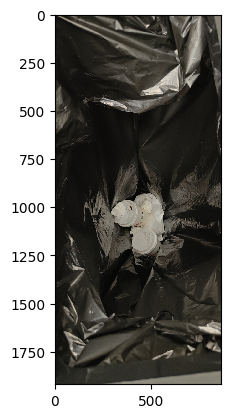

In [349]:
img_dir = './images'

img = coco.imgs[0]
image = np.array(Image.open(os.path.join(img_dir, 'Trash_fed220ac-f088-4708-9709-e23341f77d6a_74a6e7f7-4db5-41c6-9685-f3620b0d7a14_c4c093ab-ef17-45c0-9076-45b19d2a992c.jpeg')))
plt.imshow(image, interpolation='nearest')
plt.show()

In [350]:
cats

[{'supercategory': '', 'id': 1, 'name': 'Paper Cup'},
 {'supercategory': '', 'id': 2, 'name': 'Snack or Candy Bag or Wrapper '},
 {'supercategory': '', 'id': 4, 'name': 'Wipe'},
 {'supercategory': '', 'id': 5, 'name': 'Wax Paper'},
 {'supercategory': '', 'id': 6, 'name': 'Latex Gloves'},
 {'supercategory': '', 'id': 7, 'name': 'Juice or Other Pouch'},
 {'supercategory': '', 'id': 8, 'name': 'Diaper'},
 {'supercategory': '', 'id': 9, 'name': 'Padded Envelope (mixed materials)'},
 {'supercategory': '', 'id': 10, 'name': 'Blister Pack'},
 {'supercategory': '', 'id': 36, 'name': 'Plastic strapping'},
 {'supercategory': '', 'id': 11, 'name': 'Pens and Pencils'},
 {'supercategory': '', 'id': 14, 'name': 'Miscellaneous Office Supplies'},
 {'supercategory': '', 'id': 15, 'name': 'Facemask and Other PPE'},
 {'supercategory': '', 'id': 16, 'name': 'Shelf Stable Carton'},
 {'supercategory': '', 'id': 17, 'name': 'Soiled Plastic'},
 {'supercategory': '', 'id': 18, 'name': 'Soiled Metal'},
 {'super

COCO annotations being applied to the image.

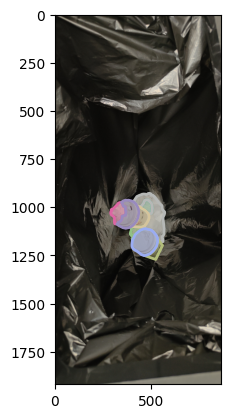

In [351]:
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

The mask produced using the category IDs to represent pixel value. Note that some parts of the image, such as the middle of the pile, appear to be dark. The exterior of the image has only zero values for its pixels, but the dead center of the pile is a plastic cup. Cups have a category ID of 1, so in this example the center still represents a classified object. 

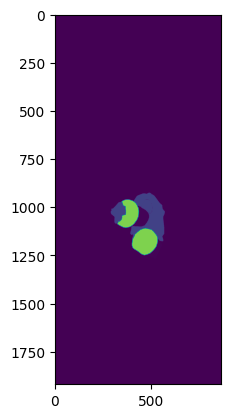

In [352]:
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])*anns[i]['category_id']
plt.imshow(mask)

Here, a second image is loaded. This will be the base image that parts of the first image will be stitched onto.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


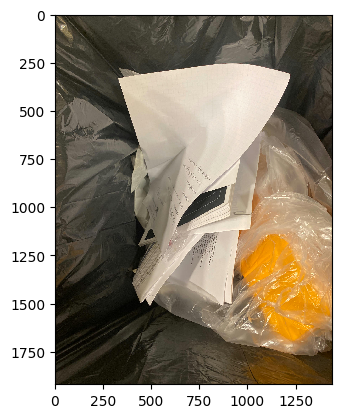

In [353]:
dataDir='./cocojson'
dataType='val'
anyFile='{}/Trash_feb7a7a0-7a9a-4ff0-b282-d68f14d9fe56_0f642e77-a98f-4840-94b0-fc9484670e14_77bbadc1-459c-4802-8c54-8502216b09f4.json'.format(dataDir,dataType)
coco2=COCO(anyFile)
img2 = coco.imgs[0]
image2 = np.array(Image.open(os.path.join(img_dir, 'Trash_feb7a7a0-7a9a-4ff0-b282-d68f14d9fe56_0f642e77-a98f-4840-94b0-fc9484670e14_77bbadc1-459c-4802-8c54-8502216b09f4.jpeg')))
plt.imshow(image2, interpolation='nearest')
plt.show()

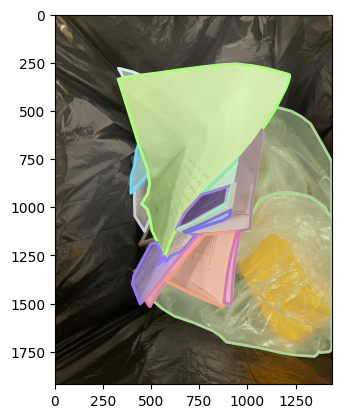

In [354]:
plt.imshow(image2)
anns_ids2 = coco2.getAnnIds(imgIds=img2['id'], catIds=cat_ids, iscrowd=None)
anns2 = coco2.loadAnns(anns_ids2)
coco.showAnns(anns2)

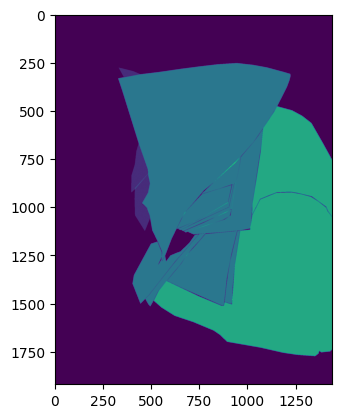

In [355]:
mask2 = np.zeros((img2['height'],1440))
for i in range(len(anns2)):
    mask2 += coco2.annToMask(anns2[i])*anns2[i]['category_id']
plt.imshow(mask2)

This crops the image so that any surrounding border of zero values is removed.

[slice(927, 1271, None), slice(290, 570, None)]


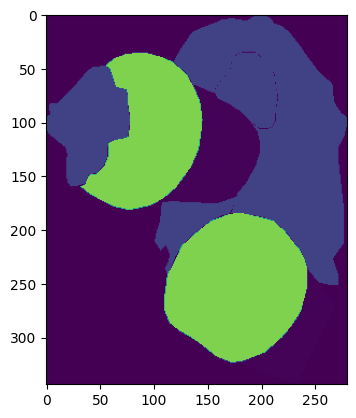

In [356]:
#https://stackoverflow.com/questions/49472962/the-fastest-way-to-exclude-surrounding-zeros-from-an-array-representing-an-image
from scipy import ndimage
def crop(arr):
    slice_x, slice_y = ndimage.find_objects(arr>0)[0]
    return arr[slice_x, slice_y]
def cropc(arr):
    slice_x, slice_y, slice_z = ndimage.find_objects(arr>0)[0]
    return arr[slice_x, slice_y, slice_z]
def crop_coord(arr):
    slice_x, slice_y = ndimage.find_objects(arr>0)[0]
    return [slice_x, slice_y]
print(crop_coord(mask))
plt.imshow(crop(mask))

In [357]:
#https://stackoverflow.com/questions/71214627/how-to-crop-an-image-by-its-mask
def apply_mask(image, mask):
    # Convert to numpy arrays
    mask = np.array(mask)
    # Convert grayscale image to RGB
    mask = np.stack((mask,)*3, axis=-1)
    # Multiply arrays
    resultant = image*mask
    return resultant

Here, a mask is generated to show only pixels that contain paper trash. This can then be translated to the original, creating a fragment of the original image that only includes one category within the JSON. 

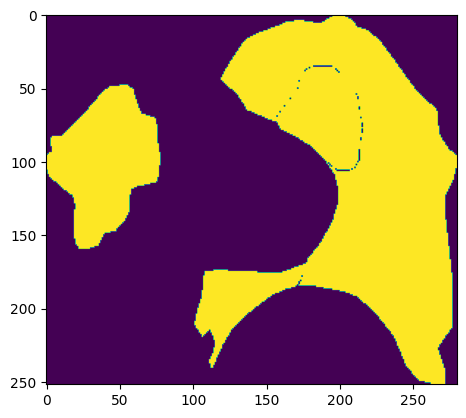

In [358]:
paper = np.where(mask == 24, 1, 0)
mask_cropped = crop(paper)*24
plt.imshow(mask_cropped)

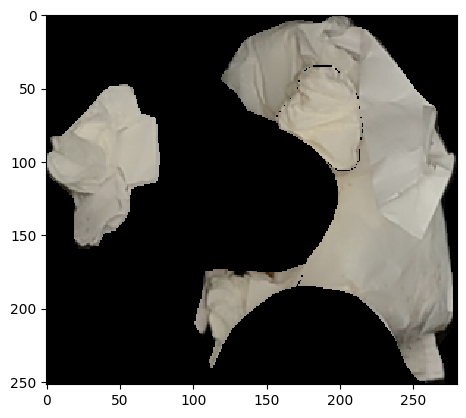

In [359]:
image_cropped = cropc(apply_mask(image, paper))
plt.imshow(image_cropped, interpolation='nearest')

Finally, the fragment is overlayed onto the base image in this example. Additionally, the mask is also overlayed, assigned the correct category id value to preserve the labels of the data. So, with this exploration, it is possible to overlay any segment from any image from within the COCO dataset onto any other image, which should allow for efficient and effective data augmentation, as well as potentially the creation of completely new images made up solely from image fragments. To improve on this, it would be necessary to generate image offsets randomly in a way that creates images that are more accurate to the original dataset.

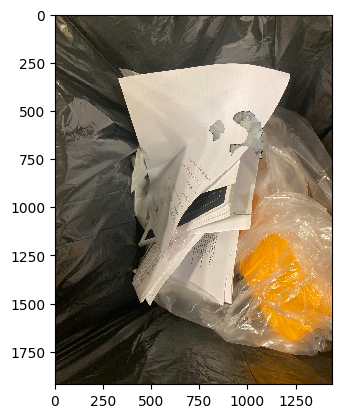

In [360]:
s_img = image_cropped
l_img = np.copy(image2)
x_offset=800
y_offset=500
y_inc = 0
for i in range(y_offset,y_offset+s_img.shape[0]):
    x_inc = 0
    for j in range(x_offset,x_offset+s_img.shape[1]):
        if(mask_cropped[y_inc, x_inc] != 0):
            l_img[i, j, :] = s_img[y_inc, x_inc, :]
            mask2[i,j] = mask_cropped[y_inc, x_inc]
        x_inc +=1
    y_inc += 1
plt.imshow(l_img, interpolation='nearest')

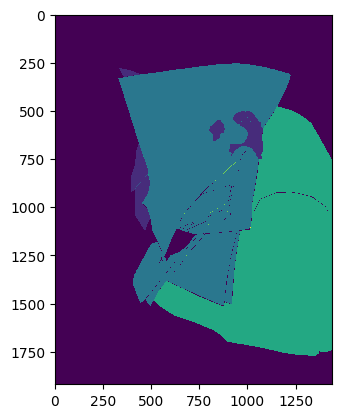

In [361]:
plt.imshow(mask2, interpolation='nearest')